# Recommending Collaborations for New and Established Artists

## Import packages

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import fim
import pickle
from surprise import (Reader, Dataset, SVDpp, SVD, SlopeOne, NMF,
                     NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans,
                     KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering)
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from collections import Counter

##  Load the Echo Nest Taste Profile Subset

In [2]:
triplets = pd.read_csv('/mnt/data/public/millionsong/taste/train_triplets.txt'
                       , sep='\t', names=['user', 'song_id', 'play_count'])

In [3]:
triplets.shape

(48373586, 3)

### Filter to songs that are played more than once by user

In [4]:
triplets = triplets[triplets['play_count']>1].reset_index(drop=True)

In [5]:
triplets.shape

(19617620, 3)

In [6]:
triplets.head(1)

,user,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2


## Load supplementary files

In [7]:
addtnl_dir = '/mnt/data/public/millionsong/AdditionalFiles/'
conn_art_sim = sql.connect(addtnl_dir + 'artist_similarity.db')
conn_art_trm = sql.connect(addtnl_dir + 'artist_term.db')
conn_tr_meta = sql.connect(addtnl_dir + 'track_metadata.db')

### Load metadata to dataframe

In [8]:
df_meta = pd.read_sql("SELECT * FROM songs", conn_tr_meta)

In [9]:
df_meta.shape

(1000000, 11)

In [10]:
df_meta.head(1)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003


### Load genre by artist to dataframe

In [11]:
df_genre = pd.read_sql("SELECT * FROM artist_mbtag", conn_art_trm)

In [12]:
df_genre.shape

(24777, 2)

In [13]:
df_genre.head(1)

,artist_id,mbtag
0,AR002UA1187B9A637D,uk


### EDA on genres

In [14]:
df_genre20 = df_genre.mbtag.value_counts()[:20].reset_index()

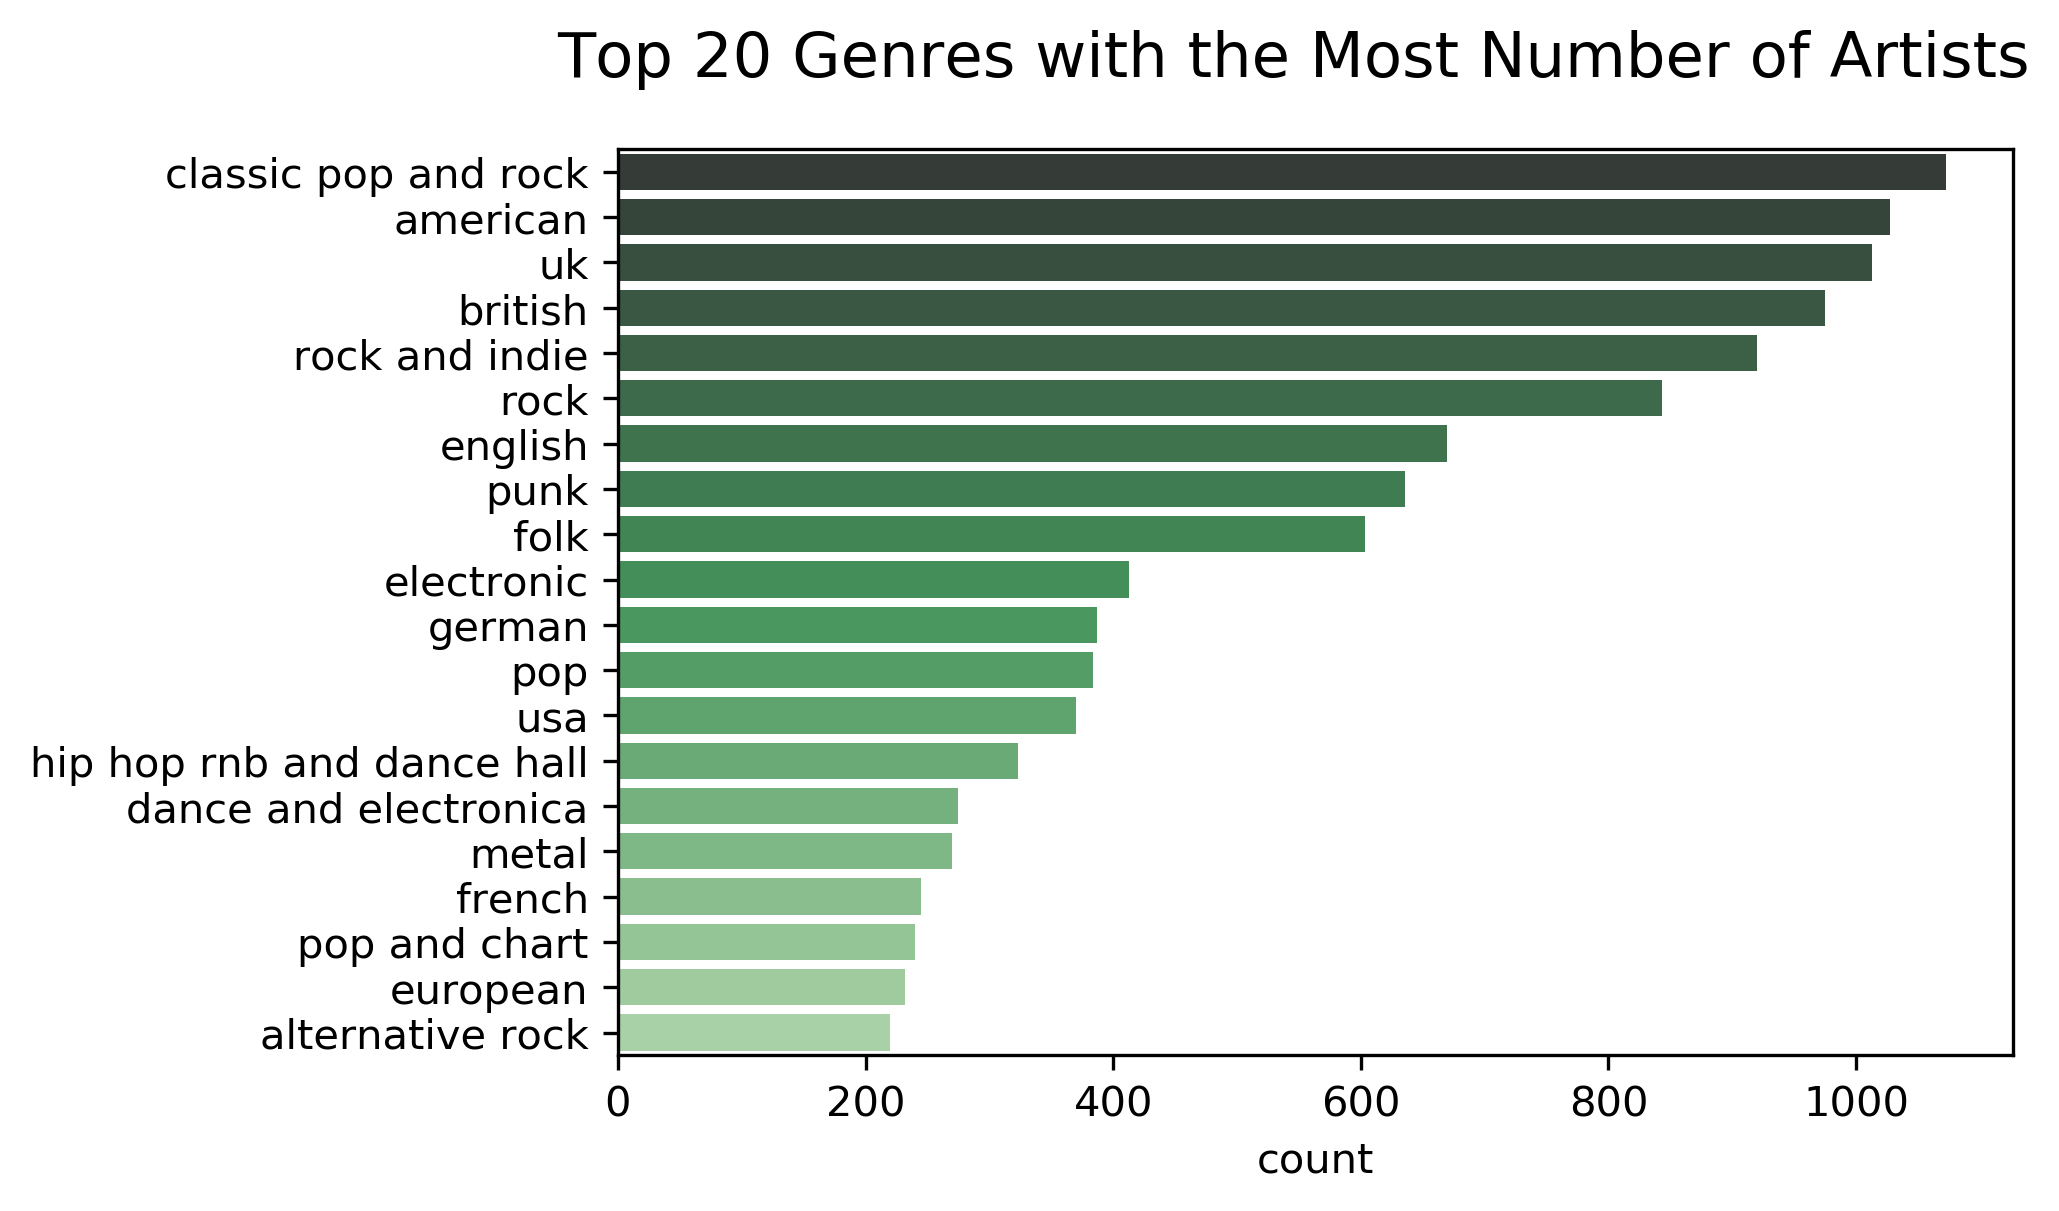

In [15]:
fig, ax = plt.subplots(dpi=300)
ax = sns.barplot(x=df_genre20.mbtag, y=df_genre20['index'], 
                 palette='Greens_d')
ax.set_xlabel('count')
ax.set_ylabel('')
fig.suptitle('Top 20 Genres with the Most Number of Artists', fontsize=15)
fig;

### 4 out of the top 20 is rock genre:

In [16]:
df_genre20[df_genre20['index'].str.contains('rock')]['index'].tolist()

['classic pop and rock', 'rock and indie', 'rock', 'alternative rock']

### Filter to rock artists only (for simplicity, filtered out duplicates)

In [17]:
df_rock_genre = df_genre[df_genre.mbtag.str.contains('rock')
                        ].drop_duplicates('artist_id').reset_index(drop=True)

In [18]:
df_rock_genre.shape

(2772, 2)

In [19]:
df_rock_genre.head(1)

,artist_id,mbtag
0,AR002UA1187B9A637D,rock


In [20]:
print(df_rock_genre.mbtag.nunique(), 'kinds of rock genre')

99 kinds of rock genre


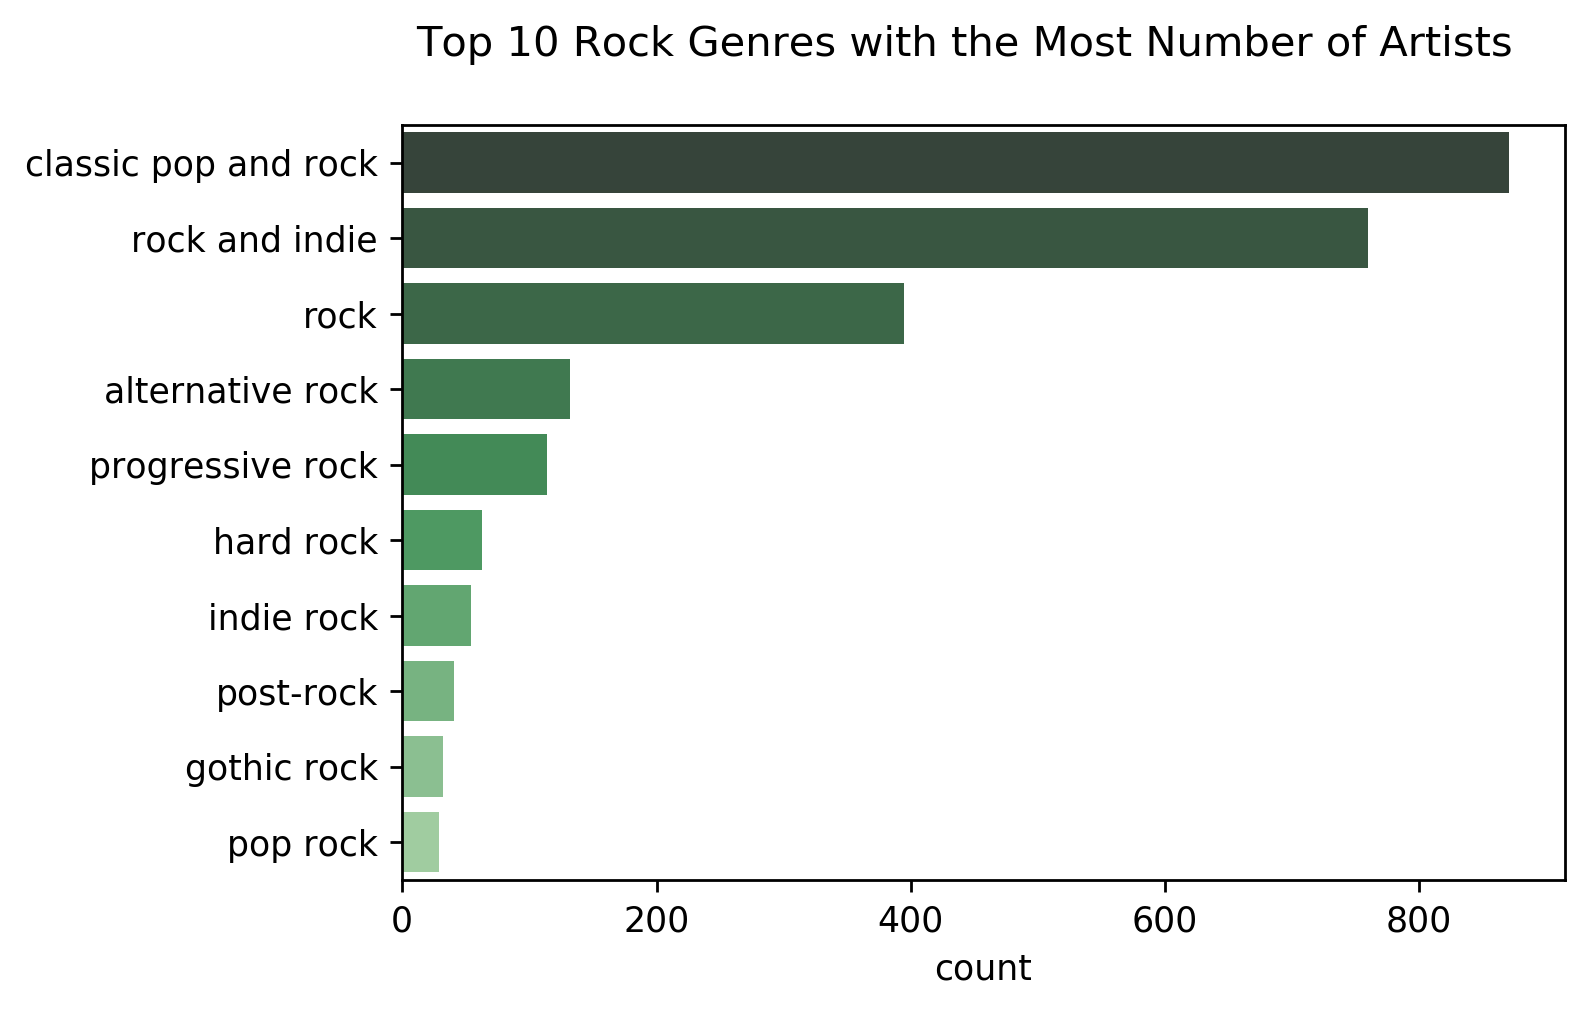

In [21]:
df_rock_genre_counts = df_rock_genre.mbtag.value_counts()[:10].reset_index()

fig, ax = plt.subplots(dpi=250)
ax = sns.barplot(x=df_rock_genre_counts.mbtag, 
                 y=df_rock_genre_counts['index'], palette='Greens_d')
ax.set_xlabel('count')
ax.set_ylabel('')
fig.suptitle('Top 10 Rock Genres with the Most Number of Artists', 
             fontsize=12)
fig;

### Join triplets with metadata and rock data to filter songs by rock artists

In [22]:
df_rock_songs = triplets.merge(df_meta.merge(df_rock_genre))

In [23]:
df_rock_songs.shape

(7295277, 14)

In [24]:
df_rock_songs.head(1)

,user,song_id,play_count,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,mbtag
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,TRPTWGR128F1452734,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,AR3SPD91187B9B63E3,4bb712d6-8be9-4c09-810a-eb3bed2be345,Héroes del Silencio,231.36608,0.672904,0.524063,2007,rock


### Convert triplets to a database (list of transactions)

In [25]:
db = df_rock_songs[['user', 'artist_id']].groupby('user'
                                                 )['artist_id'].apply(set)

In [26]:
print('Total of', len(db), 'transactions')

Total of 839034 transactions


## Frequent Itemset Mining (pyFIM FP-Growth)

In [27]:
fim_assoc_rules = sorted(fim.fpgrowth(db, target='r', supp=0.1, conf=0.1, 
                                    zmin=5, report='l'), key=lambda x: -x[2])

In [28]:
print(len(fim_assoc_rules), 'association rules')

2294712 association rules


In [29]:
fim_rel_sup = sorted(fim.fpgrowth(db, supp=0.1, conf=0.1, zmin=5, report='S'),
                             key=lambda x: -x[1])

In [30]:
fim_rel_sup[:2]

[(('ARML3X41187FB35F2E',
   'ARICCZI1187B9AEBB3',
   'AR73S4G1187B9A03C2',
   'ARF2EHS1187B994F4E',
   'ARJ7KF01187B98D717'),
  0.3896147235988053),
 (('ARQUMH41187B9AF699',
   'ARICCZI1187B9AEBB3',
   'AR73S4G1187B9A03C2',
   'ARF2EHS1187B994F4E',
   'ARJ7KF01187B98D717'),
  0.38568162911157355)]

### Create dataframe to match artist_id with artist_names (dropped duplicates)

In [31]:
df_artist_names = df_rock_songs[['artist_id', 'artist_name']
                        ].drop_duplicates('artist_id').reset_index(drop=True)

In [32]:
df_artist_names.shape

(2588, 2)

In [33]:
df_artist_names.head(1)

,artist_id,artist_name
0,AR3SPD91187B9B63E3,Héroes del Silencio


### Match frequent itemsets with artist_names

In [34]:
df_fim_rel_sup = pd.DataFrame(fim_rel_sup, columns=['artist_ids', 
                                                    'relative_support'])

In [35]:
df_fim_rel_sup['artist_names'] = df_fim_rel_sup.artist_ids.apply(
                                            lambda x: tuple(df_artist_names[
                                            df_artist_names.artist_id.isin(x)
                                            ]['artist_name']))

### Top 10 rock artists - best option for Dream Rock Concert lineup

In [36]:
top10 = df_fim_rel_sup.loc[:18, ['artist_ids', 'artist_names']
                          ].set_index('artist_ids').to_dict()['artist_names']

In [37]:
top10_ids = set(item for subl in list(top10.keys()) for item in subl)
top10_names = set(item for subl in list(top10.values()) for item in subl)
top10_names

{'3 Doors Down',
 'Björk',
 'Bon Jovi',
 'Coldplay',
 'Jason Mraz & Colbie Caillat',
 'Kings Of Leon',
 'Linkin Park',
 'Lonnie Gordon',
 'OneRepublic',
 'Train'}

In [38]:
print('Range of their relative supports:', 
          df_fim_rel_sup.loc[:18, 'relative_support'].max(), '-', 
          df_fim_rel_sup.loc[:18, 'relative_support'].min())

Range of their relative supports: 0.3896147235988053 - 0.20559357546893214


### EDA on top 10 artists

In [39]:
df_top10 = df_rock_songs[df_rock_songs.artist_id.isin(list(top10_ids))]

In [40]:
grp = df_top10.groupby('artist_id')
df_top10_stats = grp['user'].count().reset_index().merge(
                 grp['play_count'].sum().reset_index()).merge(
                 df_top10[df_top10.year>0].groupby('artist_id')['year'
                                                ].min().reset_index()).merge(
                 grp['year'].max().reset_index(), on='artist_id'
                    ).sort_values('user', ascending=False)
df_top10_stats['Artist'] = df_top10_stats.artist_id.apply(lambda x: 
                                df_artist_names[df_artist_names.artist_id==x
                                ]['artist_name'].values[0])
df_top10_stats.user = df_top10_stats.user/1000
df_top10_stats.play_count = df_top10_stats.play_count/1000

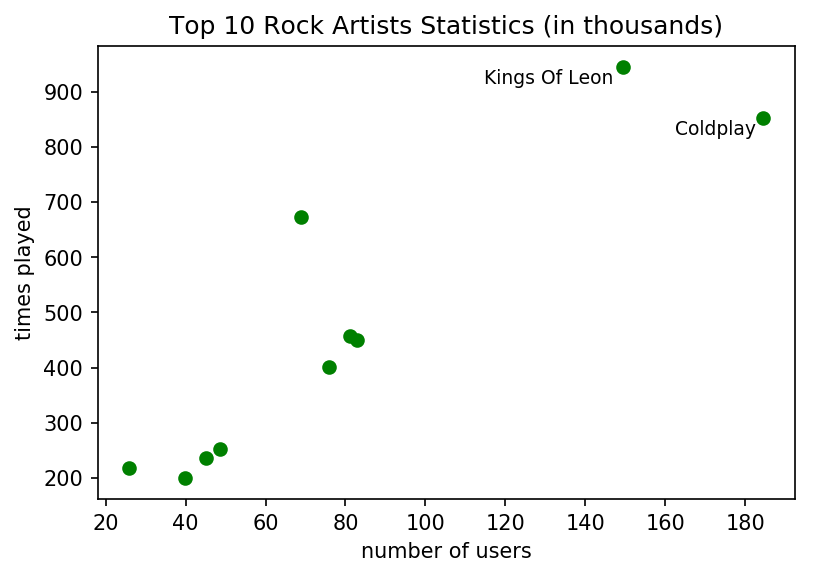

In [41]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(x='user', y='play_count', data=df_top10_stats, color='green')
top1, top2 = df_top10_stats.loc[6], df_top10_stats.loc[4]
ax.text(top1['user']-22, top1['play_count']-30, top1['Artist'], fontsize=9)
ax.text(top2['user']-35, top2['play_count']-30, top2['Artist'], fontsize=9)
ax.set_xlabel('number of users')
ax.set_ylabel('times played')
ax.set_title('Top 10 Rock Artists Statistics (in thousands)')
fig;

### Among the top 10 rock artists,
**Coldplay has the `most listeners (184K users)`:**

In [78]:
trial = df_top10_stats[['Artist', 'user', 'play_count']]

In [81]:
trial.reset_index(drop=True)

,Artist,Number of Users,Total Play Count
0,Coldplay,184.553,852.810
1,Kings Of Leon,149.530,945.125
2,Train,82.862,449.922
3,OneRepublic,81.030,457.876
4,Linkin Park,75.796,400.307
5,Björk,68.826,672.944
6,3 Doors Down,48.703,252.894
7,Jason Mraz & Colbie Caillat,45.230,236.730
8,Bon Jovi,39.795,198.930
9,Lonnie Gordon,25.949,217.928


In [42]:
df_top10_stats[:1]

,artist_id,user,play_count,year_x,year_y,Artist
6,ARJ7KF01187B98D717,184.553,852.81,1998,2009,Coldplay


**Kings Of Leon's songs have been `played the most (945K times)`:**

In [43]:
df_top10_stats.sort_values('play_count', ascending=False)[:1]

,artist_id,user,play_count,year_x,year_y,Artist
4,ARF2EHS1187B994F4E,149.53,945.125,2003,2008,Kings Of Leon


**Interestingly, Kings of Leon has been in the industry way sooner than Coldplay, but has more songs played and almost as much listeners as them.**

### Bottom 5 itemsets:
Note: This still has at least 10% relative support.

In [44]:
df_fim_rel_sup[['artist_names', 'relative_support']].tail(5)

,artist_names,relative_support
766,"(OneRepublic, Kings Of Leon, Coldplay, MGMT, S...",0.100234
767,"(OneRepublic, Coldplay, Linkin Park, Bon Jovi,...",0.100115
768,"(Björk, OneRepublic, Coldplay, Jason Mraz & Co...",0.100115
769,"(OneRepublic, Kings Of Leon, Coldplay, Jason M...",0.100115
770,"(OneRepublic, Kings Of Leon, Train, Plain Whit...",0.100115


In [45]:
bottom5_names = set(item for sublist in df_fim_rel_sup.tail(5)['artist_names'
                                ].tolist() for item in sublist) - top10_names

### However, all of these artists are also on top, except from these 5 artists:

In [46]:
bottom5_names

{'MGMT', "Plain White T's", 'Radiohead', 'Simon Harris', 'The Killers'}

**This means, although not included in the top 10, these 5 artists are the best options to be in the `opening act lineup` in the Dream Rock Concert since they have belonged to itemsets with the most popular artists.**

### EDA on bottom 5 artists

In [47]:
bottom5_ids = set(df_rock_songs[df_rock_songs.artist_name.isin(
                            list(bottom5_names))]['artist_id'])

In [48]:
df_bottom5 = df_rock_songs[df_rock_songs.artist_id.isin(bottom5_ids)]

In [49]:
grp2 = df_bottom5.groupby('artist_id')
df_bottom5_stats = grp2['user'].count().reset_index().merge(
                   grp2['play_count'].sum().reset_index()).merge(
                   df_bottom5[df_bottom5.year>0].groupby('artist_id')['year'
                                                ].min().reset_index()).merge(
                   grp2['year'].max().reset_index(), on='artist_id'
                      ).sort_values('user', ascending=False)
df_bottom5_stats['Artist'] = df_bottom5_stats.artist_id.apply(lambda x: 
                                df_artist_names[df_artist_names.artist_id==x
                                ]['artist_name'].values[0])
df_bottom5_stats.user = df_bottom5_stats.user/1000
df_bottom5_stats.play_count = df_bottom5_stats.play_count/1000

In [50]:
df_bottom5_stats

,artist_id,user,play_count,year_x,year_y,Artist
0,ARH6W4X1187B99274F,85.891,395.793,1992,2009,Radiohead
2,ARVG4OK1187B9B6BD3,79.452,369.045,2003,2009,The Killers
1,ARI3Y821187FB3649C,29.488,138.305,2005,2010,MGMT
4,ARXGKVD1187FB54D8F,17.404,84.429,2002,2010,Plain White T's
3,ARWR05M1187B9951A2,14.026,66.675,1976,1988,Simon Harris


In [114]:
trial = df_bottom5_stats[['Artist', 'user', 'play_count']].reset_index(drop=True)
trial.reset_index(drop=True)
trial.columns = ['Artist', 'Number of Users', 'Total Play Count (in thousands)']
trial

,Artist,Number of Users,Total Play Count (in thousands)
0,Radiohead,85.891,395.793
1,The Killers,79.452,369.045
2,MGMT,29.488,138.305
3,Plain White T's,17.404,84.429
4,Simon Harris,14.026,66.675


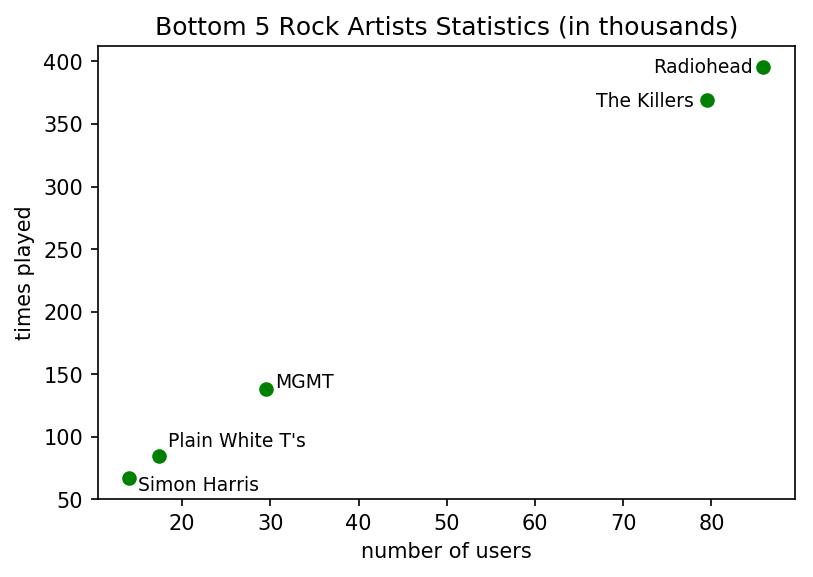

In [51]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(x='user', y='play_count', data=df_bottom5_stats, color='green')
a, b = df_bottom5_stats.loc[0], df_bottom5_stats.loc[2]
c, d = df_bottom5_stats.loc[1], df_bottom5_stats.loc[4]
e = df_bottom5_stats.loc[3]
ax.text(a['user']-12.5, a['play_count']-5, a['Artist'], fontsize=9)
ax.text(b['user']-12.5, b['play_count']-5, b['Artist'], fontsize=9)
ax.text(c['user']+1, c['play_count']+1, c['Artist'], fontsize=9)
ax.text(d['user']+1, d['play_count']+8, d['Artist'], fontsize=9)
ax.text(e['user']+1, e['play_count']-10, e['Artist'], fontsize=9)
ax.set_xlabel('number of users')
ax.set_ylabel('times played')
ax.set_title('Bottom 5 Rock Artists Statistics (in thousands)')
fig;

### Among the bottom 5 rock artists,
**Radiohead has the `most listeners (85K users)` and the `most number of songs played (395K times)`:**

In [52]:
df_bottom5_stats.sort_values('user', ascending=False)[:1]

,artist_id,user,play_count,year_x,year_y,Artist
0,ARH6W4X1187B99274F,85.891,395.793,1992,2009,Radiohead


In [53]:
df_bottom5_stats.sort_values('play_count', ascending=False)[:1]

,artist_id,user,play_count,year_x,year_y,Artist
0,ARH6W4X1187B99274F,85.891,395.793,1992,2009,Radiohead


## Multiple Recommender System Algorithms (Surprise)

In [60]:
df_rock_songs.head(1)

,user,song_id,play_count,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,mbtag
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,TRPTWGR128F1452734,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,AR3SPD91187B9B63E3,4bb712d6-8be9-4c09-810a-eb3bed2be345,Héroes del Silencio,231.36608,0.672904,0.524063,2007,rock


In [61]:
df_main = df_rock_songs[['user', 'artist_id', 'play_count']].groupby(
                    ['user', 'artist_id'])['play_count'].sum().reset_index()

### Sample only 10K

In [84]:
df_main_10K = df_main.sample(n=10000)

In [85]:
df_main_10K.shape

(10000, 3)

### Scale play_count to 1, 2, 3 (based on the original data, not on the sample)

In [86]:
x1 = df_main['play_count'].quantile(0)
x2 = df_main['play_count'].quantile(0.25)
x3 = df_main['play_count'].quantile(0.5)
x4 = df_main['play_count'].quantile(0.75)

In [87]:
def convert_quantile(x):
    if x >= x4:
        x = 4
    elif x >= x3:
        x = 3
    elif x >= x2:
        x = 2
    elif x >= x1:
        x = 1
    return x

In [88]:
df_main_10K['play_count'] = df_main_10K['play_count'].apply(convert_quantile)

In [89]:
df_main_10K.head(1)

,user,artist_id,play_count
4365313,fecfbb20449126bd3dcc7d1079ac6865a3648575,ARE8GLF1187FB52532,4


### Multiple RS modelling

In [90]:
reader = Reader(rating_scale=(1, 3))

data = Dataset.load_from_df(df_main_10K, reader)

benchmark = []

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), 
                  KNNBaseline(), KNNBasic(), BaselineOnly(), CoClustering()]:

    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, 
                             verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], 
                               index=['Algorithm']))
    benchmark.append(tmp)
    
df_rs = pd.DataFrame(benchmark).set_index('Algorithm'
                                         ).sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [91]:
df_rs

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.835507,1.326037,0.026733
SVD,0.837182,0.402972,0.024434
SVDpp,0.837681,0.726477,0.023211
KNNBasic,0.837838,1.285279,0.025311
BaselineOnly,0.838700,0.026057,0.020633
SlopeOne,0.839309,0.089370,0.021998
CoClustering,0.839323,0.671220,0.017693
NMF,0.840956,0.834073,0.022721
NormalPredictor,1.022942,0.009129,0.023276


In [96]:
df_rs_plot = df_rs[['test_rmse']].reset_index()

In [98]:
df_rs_plot

,Algorithm,test_rmse
0,KNNBaseline,0.835507
1,SVD,0.837182
2,SVDpp,0.837681
3,KNNBasic,0.837838
4,BaselineOnly,0.838700
5,SlopeOne,0.839309
6,CoClustering,0.839323
7,NMF,0.840956
8,NormalPredictor,1.022942


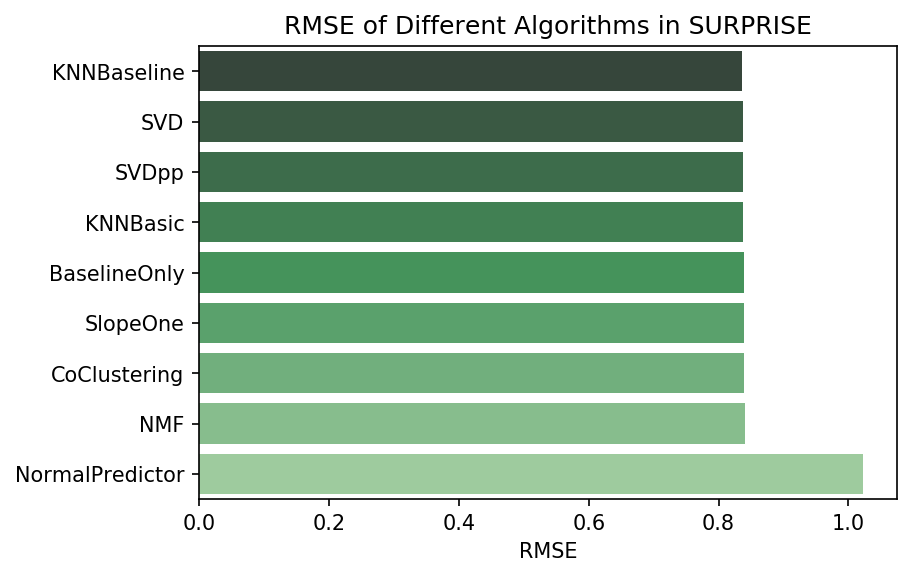

In [107]:
fig, ax = plt.subplots(dpi=150)
ax = sns.barplot(x=df_rs_plot.test_rmse, y=df_rs_plot.Algorithm,  
                 palette='Greens_d')
ax.set_xlabel('RMSE')
ax.set_ylabel('')
ax.set_title('RMSE of Different Algorithms in SURPRISE')
fig;

### Prediction from the best RS algorithm - BaselineOnly (lowest RMSE)

In [92]:
trainset, testset = train_test_split(data, test_size=0.25)

best_rs = KNNBaseline()

predictions = best_rs.fit(trainset).test(testset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [120]:
df_pred = pd.DataFrame(predictions).sort_values('est', ascending=False)

In [125]:
df_pred = df_pred[['uid', 'iid', 'est']]
df_pred.columns = ['user', 'artist_id', 'pred_play_count']

In [127]:
df_pred_name = df_pred.merge(df_artist_names)

In [137]:
df_pred_name.head(2)

,user,artist_id,pred_play_count,artist_name
0,86cb0d540760b9c11f7f2b30008dbb207edbada2,AR76NY61187FB4F82F,3.0,Ben Folds
1,3d0900d83e4d85319f0c40c22782b630efc7628d,AR76NY61187FB4F82F,3.0,Ben Folds


In [142]:
df_pred_name.groupby('artist_name')['pred_play_count'].sum().head(10
            ).reset_index().sort_values('pred_play_count', ascending=False
                                       ).reset_index(drop=True)

,artist_name,pred_play_count
0,3 Doors Down,36.920529
1,A Day To Remember,24.225652
2,311,8.583396
3,1990s,5.844286
4,36 Crazyfists,5.750857
5,...And You Will Know Us By The Trail Of Dead,5.540000
6,4 Non Blondes,5.276851
7,38 Special,3.000000
8,10_000 Maniacs,2.770000
9,65daysofstatic,2.648421
